# Making Predictions in Generative Model

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
iris_df = sns.load_dataset('iris')

We'll  load the data again

In [2]:
iris_df.head(1)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa


Next we indicate the feature variables and target and split into test and train
sets.  Well use 80% of the data for training.

In [3]:
feature_vars = ['sepal_length', 'sepal_width','petal_length', 'petal_width',]
target_var = 'species'

X_train, X_test, y_train, y_test = train_test_split(iris_df[feature_vars],
                          iris_df[target_var], train_size=.8, random_state=0)

We can confirm the shape is as expected

In [4]:
X_train.shape

(120, 4)

In [5]:
iris_df.shape

(150, 5)

In [6]:
.8*150

120.0

Next we again initialize and fit the classifier

In [7]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

We can compute predictions

In [8]:
y_pred = gnb.predict(X_test)
y_pred

array(['virginica', 'versicolor', 'setosa', 'virginica', 'setosa',
       'virginica', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'setosa', 'versicolor', 'versicolor', 'setosa',
       'setosa', 'virginica', 'versicolor', 'setosa', 'setosa',
       'virginica', 'setosa', 'setosa', 'versicolor', 'versicolor',
       'setosa'], dtype='<U10')

And score the results

In [9]:
gnb.score(X_test,y_test)

0.9666666666666667

We saw last week that when we fit the Gaussian Naive Bayes, it computes a mean
$\theta$ and variance $\sigma$ and adds them to model parameters in attributes
`gnb.theta_, gnb.sigma_`.

When we use the predict method, it uses those parameters to calculate the
likelihood of the sample according to a Gaussian distribution (normal) for each
class and then calculates the probability of the sample belonging to each class.

In [10]:
gnb.predict_proba(X_test)

array([[1.63380783e-232, 2.18878438e-006, 9.99997811e-001],
       [1.82640391e-082, 9.99998304e-001, 1.69618390e-006],
       [1.00000000e+000, 7.10250510e-019, 3.65449801e-028],
       [1.58508262e-305, 1.04649020e-006, 9.99998954e-001],
       [1.00000000e+000, 8.59168655e-017, 4.22159374e-027],
       [6.39815011e-321, 1.56450314e-010, 1.00000000e+000],
       [1.00000000e+000, 1.09797313e-016, 5.30276557e-027],
       [1.25122812e-146, 7.74052109e-001, 2.25947891e-001],
       [5.34357526e-150, 9.07564955e-001, 9.24350453e-002],
       [5.67261712e-093, 9.99882109e-001, 1.17891111e-004],
       [2.38651144e-210, 5.29609631e-001, 4.70390369e-001],
       [8.12047631e-132, 9.43762575e-001, 5.62374248e-002],
       [5.25177109e-132, 9.98864361e-001, 1.13563851e-003],
       [1.24498038e-139, 9.49838641e-001, 5.01613586e-002],
       [4.08232760e-140, 9.88043864e-001, 1.19561365e-002],
       [1.00000000e+000, 7.12837229e-019, 4.10162749e-029],
       [4.19553996e-131, 9.87944980e-001

These are hard to interpret as is, one option is to plot them

In [11]:
# make the prbabilities into a dataframe labeled with classes & make the index a separate column
prob_df = pd.DataFrame(data = gnb.predict_proba(X_test), columns = gnb.classes_ ).reset_index()
# add the predictions
prob_df['predicted_species'] = y_pred
prob_df['true_species'] = y_test.values
# for plotting, make a column that combines the index & prediction
pred_text = lambda r: str( r['index']) + ',' + r['predicted_species']
prob_df['i,pred'] = prob_df.apply(pred_text,axis=1)
# same for ground truth
true_text = lambda r: str( r['index']) + ',' + r['true_species']
prob_df['correct'] = prob_df['predicted_species'] == prob_df['true_species']
# a dd a column for which are correct
prob_df['i,true'] = prob_df.apply(true_text,axis=1)
prob_df_melted = prob_df.melt(id_vars =[ 'index', 'predicted_species','true_species','i,pred','i,true','correct'],value_vars = gnb.classes_,
                             var_name = target_var, value_name = 'probability')
prob_df_melted.head()

,index,predicted_species,true_species,"i,pred","i,true",correct,species,probability
0,0,virginica,virginica,"0,virginica","0,virginica",True,setosa,1.633808e-232
1,1,versicolor,versicolor,"1,versicolor","1,versicolor",True,setosa,1.826404e-82
2,2,setosa,setosa,"2,setosa","2,setosa",True,setosa,1.000000e+00
3,3,virginica,virginica,"3,virginica","3,virginica",True,setosa,1.585083e-305
4,4,setosa,setosa,"4,setosa","4,setosa",True,setosa,1.000000e+00


Now we have a data frame where each rown is one the probability of one sample belonging to one class. So there's a total of `number_of_samples*number_of_classes` rows

In [12]:
prob_df_melted.shape

(90, 8)

In [13]:
len(y_pred)*len(gnb.classes_)

90

One way to look at these is to, for each sample in the test set, make a bar chart of the probability it belongs to each class.  We added to the data frame information so that we can plot this with the true class in the title using `col = 'i,true'`

````{margin}
```{tip}
I used `set_theme` to change both the fond size and the color palette.
Seaborn has a [detailed guide](https://seaborn.pydata.org/tutorial/color_palettes.html#palette-tutorial)
for choosing colors. The `colorblind` palette uses colors that are distinguishable under most common
forms of color blindness.
```
````

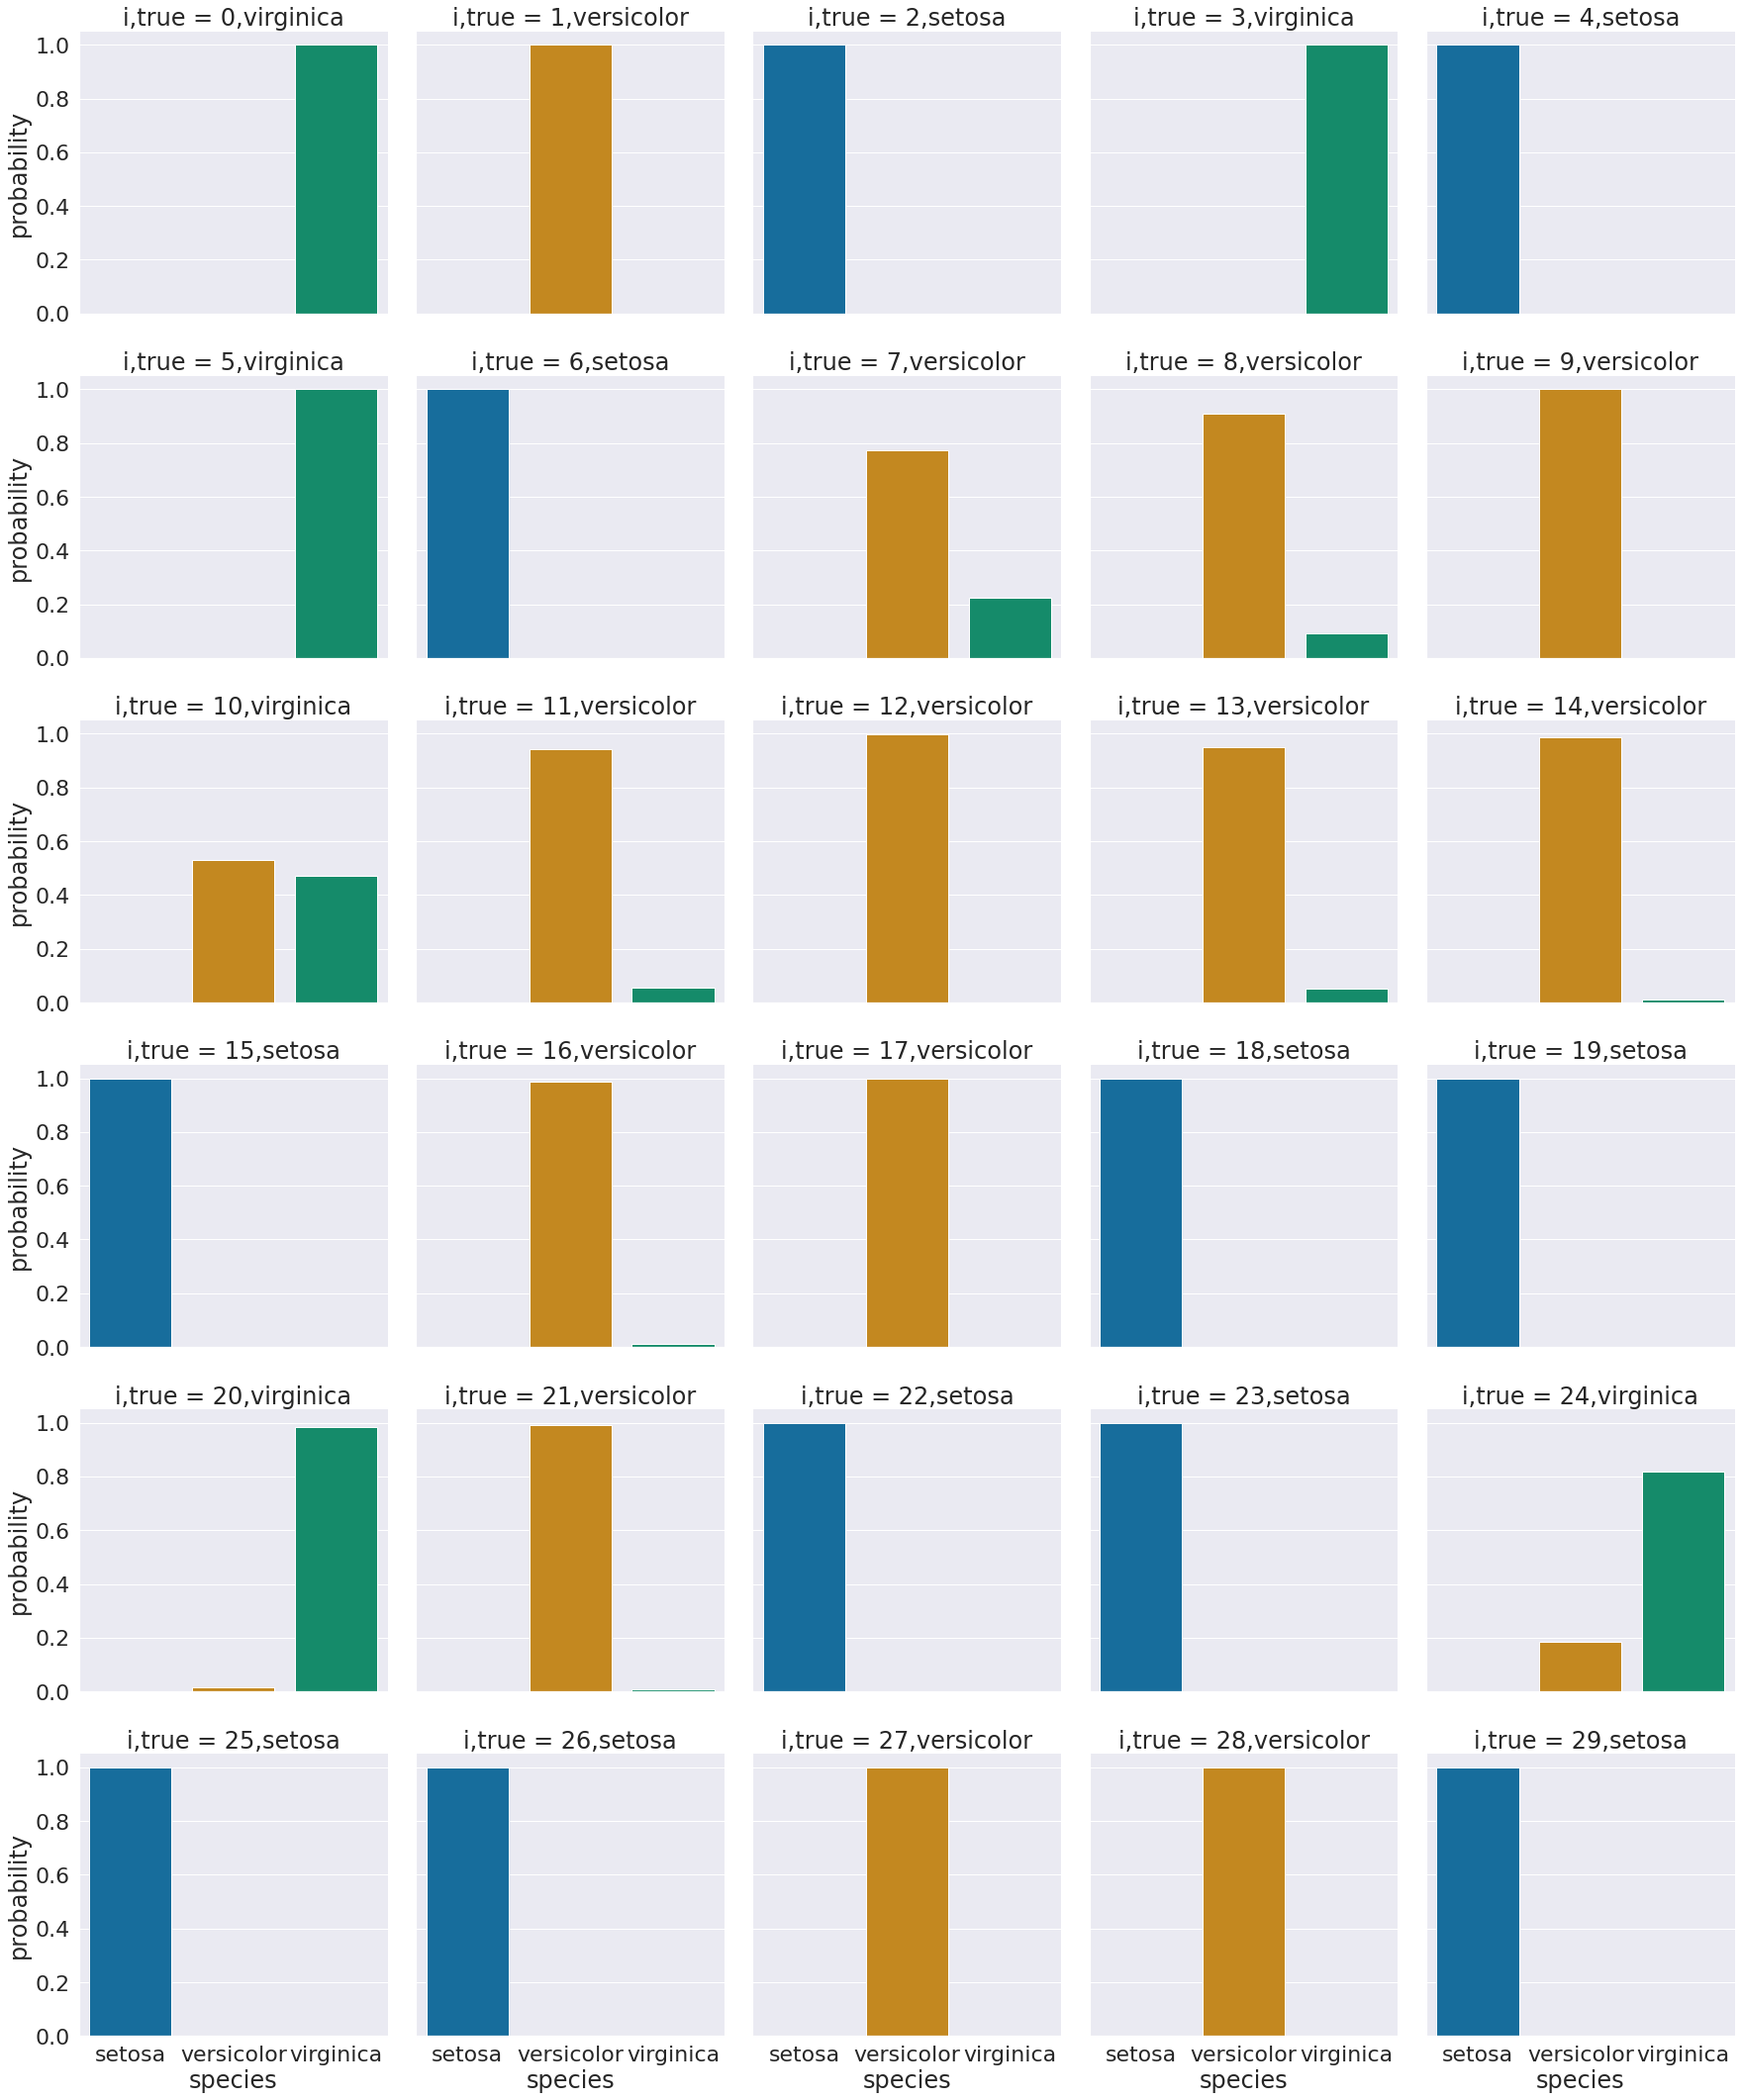

In [14]:
sns.set_theme(font_scale=2, palette= "colorblind")
# plot a bar graph for each point labeled with the prediction
sns.catplot(data =prob_df_melted, x = 'species', y='probability' ,col ='i,true',
            col_wrap=5,kind='bar')

We see that most sampples have nearly all of their probability mass (all probabiilties in a distribution sum (or integrate if continuous) to 1, but a few samples are not.  

```{admonition} Try it yourself
Try adding a column that could change the headings to include an indicator of which are correct or not)
```

For now, we'll group and look at on average, what the distributions are for correct vs incorrect based on predictions.

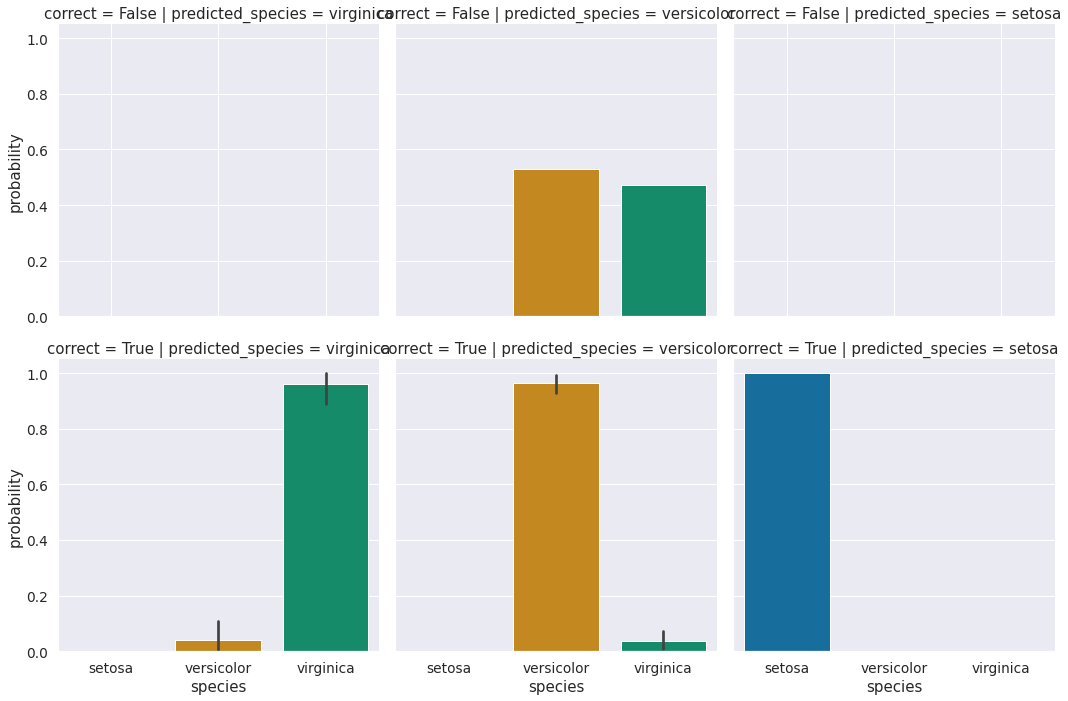

In [15]:
sns.set(font_scale=1.25, palette= "colorblind")
sns.catplot(data =prob_df_melted, x = 'species', y='probability' ,
            col ='predicted_species',row ='correct', kind='bar')

We see that the errors were all for versicolor, and on average the distribution is very uncertain for those samples.  Those samples are probably hard to distinguish. We could check by creating a data frame with the data and the information about predictions and correct values.

In [16]:
prob_data_df = pd.concat([prob_df,X_test.reset_index()],axis=1).drop(columns=['index'])
prob_data_df.head(2)

,setosa,versicolor,virginica,predicted_species,true_species,"i,pred",correct,"i,true",sepal_length,sepal_width,petal_length,petal_width
0,1.633808e-232,0.000002,0.999998,virginica,virginica,"0,virginica",True,"0,virginica",5.8,2.8,5.1,2.4
1,1.826404e-82,0.999998,0.000002,versicolor,versicolor,"1,versicolor",True,"1,versicolor",6.0,2.2,4.0,1.0


In [17]:
feature_vars

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

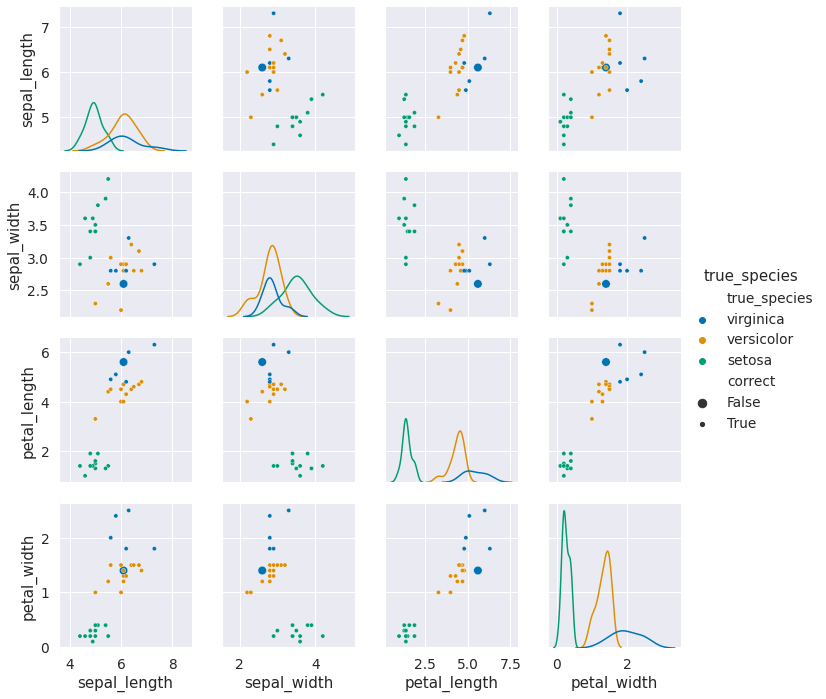

In [18]:
g = sns.PairGrid(prob_data_df,x_vars=feature_vars,y_vars= feature_vars,hue='true_species')

g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot, size=prob_data_df["correct"])

g.add_legend()

Here we see that the large dots (the incorrect ones) are all nearby to points of a different color.  They were in fact samples that are similar to the other species.  So again, this result makes sense and helps us see when classifiers that are a good fit for the data will still make mistakes.

We can also look at the probabilites of the predicted sample using max

In [19]:
p_predicted = np.max(gnb.predict_proba(X_test),axis=1)
p_predicted

array([0.99999781, 0.9999983 , 1.        , 0.99999895, 1.        ,
       1.        , 1.        , 0.77405211, 0.90756495, 0.99988211,
       0.52960963, 0.94376258, 0.99886436, 0.94983864, 0.98804386,
       1.        , 0.98794498, 0.99994238, 1.        , 1.        ,
       0.98330332, 0.99275723, 1.        , 1.        , 0.81648378,
       1.        , 1.        , 0.99929123, 0.99999997, 1.        ])

We see here that most of the predictions are pretty confident.
We can also use the probabilities to then compute predictions and compare these to what the `predict` method gave, to confirm that this is how the predict method works.

In [20]:
pd.DataFrame(data = gnb.predict_proba(X_test), columns = gnb.classes_ ).idxmax(axis=1) ==y_pred

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
dtype: bool